**Atividade 3.2 disciplina RNA e Deep Learning**

**Aluna: Eveline Cavalcanti Feliciano Pontual**

# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


<ipython-input-5-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

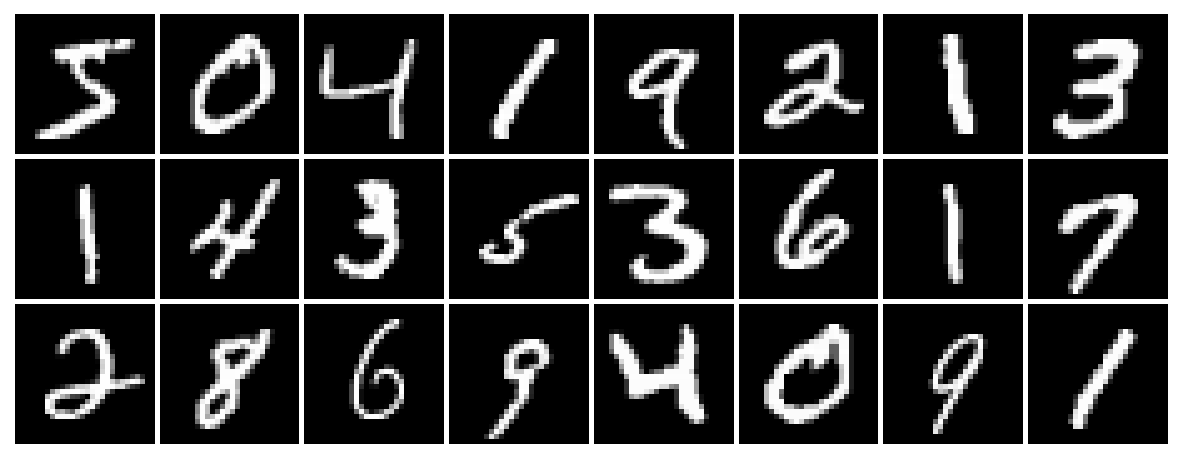

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


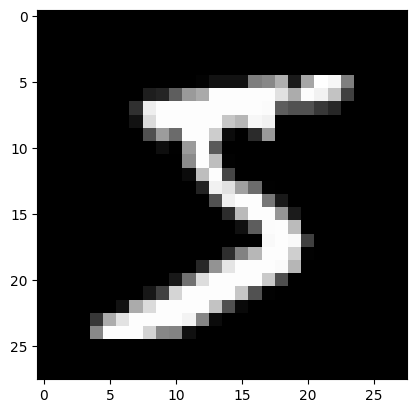

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [9]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [10]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.0933,  0.2589, -0.1744, -0.0617,  0.1163, -0.2235,  0.2270,  0.3124,
         -0.1353, -0.2085],
        [-0.3083,  0.2278, -0.0763, -0.1015,  0.3361, -0.3803,  0.1346,  0.3272,
         -0.1216, -0.2108],
        [-0.0742, -0.1081, -0.0142, -0.2581,  0.0354, -0.2989,  0.0145, -0.2080,
          0.0999, -0.2138],
        [ 0.1079,  0.1210, -0.0575, -0.0593,  0.1141, -0.0651,  0.1196,  0.1618,
         -0.2145,  0.0080],
        [ 0.0710,  0.0368, -0.4225, -0.0871,  0.1226, -0.2939, -0.2792,  0.1465,
         -0.2014, -0.0587]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [11]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [12]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-sp41aslz
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-sp41aslz
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=40fcd44966db0e3c53b1fe60aaa0bd5f124ca8db357b002974f3d358bb0e65fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-_uvq1ikm/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


In [13]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3349, grad_fn=<NllLossBackward0>)

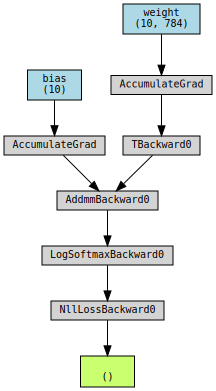

In [14]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [15]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [16]:
print('Final loss:', loss.item())

Final loss: 0.26528891921043396


### Visualizando gráfico de perda durante o treinamento

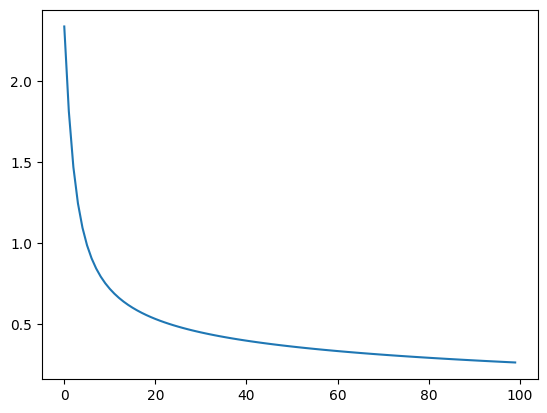

In [17]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [18]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.941


### Matriz de confusão com dados de treinamento e teste

In [19]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,3,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,1,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,2,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


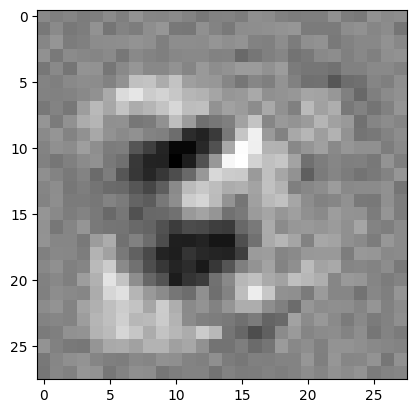

In [20]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

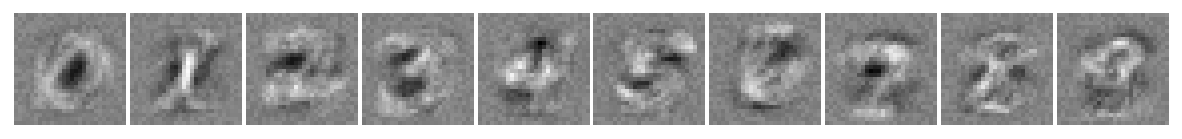

In [21]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [22]:
losses = []
zs = []

for i in range(epochs):
    # Transformar a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predição da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # Calcular a perda
    loss = criterion(outputs, Variable(y_train))

    # Zero, backpropagation, ajustar parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # Imprimir o número da época, a perda e a acurácia
    print(f'Época [{i+1}/{epochs}], Perda: {loss.item():.4f}, Acurácia: {accuracy:.4f}')


Época [1/100], Perda: 0.2640, Acurácia: 0.9410
Época [2/100], Perda: 0.2626, Acurácia: 0.9410
Época [3/100], Perda: 0.2613, Acurácia: 0.9410
Época [4/100], Perda: 0.2600, Acurácia: 0.9410
Época [5/100], Perda: 0.2588, Acurácia: 0.9420
Época [6/100], Perda: 0.2575, Acurácia: 0.9420
Época [7/100], Perda: 0.2563, Acurácia: 0.9420
Época [8/100], Perda: 0.2550, Acurácia: 0.9430
Época [9/100], Perda: 0.2538, Acurácia: 0.9440
Época [10/100], Perda: 0.2526, Acurácia: 0.9440
Época [11/100], Perda: 0.2514, Acurácia: 0.9440
Época [12/100], Perda: 0.2502, Acurácia: 0.9440
Época [13/100], Perda: 0.2491, Acurácia: 0.9440
Época [14/100], Perda: 0.2479, Acurácia: 0.9450
Época [15/100], Perda: 0.2468, Acurácia: 0.9450
Época [16/100], Perda: 0.2457, Acurácia: 0.9460
Época [17/100], Perda: 0.2445, Acurácia: 0.9460
Época [18/100], Perda: 0.2434, Acurácia: 0.9460
Época [19/100], Perda: 0.2423, Acurácia: 0.9480
Época [20/100], Perda: 0.2413, Acurácia: 0.9480
Época [21/100], Perda: 0.2402, Acurácia: 0.9480
É

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
losses = []
zs = []

for i in range(epochs):
    # Transformar a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predição da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # Calcular a perda
    loss = criterion(outputs, Variable(y_train))

    # Zero, backpropagation, ajustar parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # Imprimir o número da época, a perda e a acurácia
    print(f'Época [{i+1}/{epochs}], Perda: {loss.item():.4f}, Acurácia: {accuracy:.4f}')

    # Visualizar gradientes referentes à classe 4
    if i % 1 == 0:
        # Pega os gradientes dos parâmetros para a classe 4
        for name, param in model.named_parameters():
            if param.grad is not None:
                # Extrair e mostrar o gradiente médio para a classe 4
                grads_class_4 = param.grad.data
                print(f'Gradientes para o parâmetro {name} (Classe 4):')
                print(grads_class_4.mean().item())  # Média do gradiente de cada parâmetro


Época [1/100], Perda: 0.1780, Acurácia: 0.9670
Gradientes para o parâmetro weight (Classe 4):
-5.835614977356407e-12
Gradientes para o parâmetro bias (Classe 4):
1.6298144778215118e-10
Época [2/100], Perda: 0.1774, Acurácia: 0.9670
Gradientes para o parâmetro weight (Classe 4):
-3.409305823764974e-11
Gradientes para o parâmetro bias (Classe 4):
-3.376044444003412e-10
Época [3/100], Perda: 0.1768, Acurácia: 0.9670
Gradientes para o parâmetro weight (Classe 4):
1.0186340486384449e-11
Gradientes para o parâmetro bias (Classe 4):
6.984919587171845e-11
Época [4/100], Perda: 0.1763, Acurácia: 0.9680
Gradientes para o parâmetro weight (Classe 4):
1.0446195991553608e-11
Gradientes para o parâmetro bias (Classe 4):
1.396983917434369e-10
Época [5/100], Perda: 0.1757, Acurácia: 0.9680
Gradientes para o parâmetro weight (Classe 4):
1.934810818504662e-11
Gradientes para o parâmetro bias (Classe 4):
1.396983917434369e-10
Época [6/100], Perda: 0.1751, Acurácia: 0.9680
Gradientes para o parâmetro weig

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

**1. Qual é o shape da matriz de entrada na rede?**
  Para responder as três questões, levei em consideração as seguintes dimensões dos dados das imagens:    torch.Size([1000, 28, 28]) e o código do modelo - model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida.

  O número de entradas para cada imagem é 28*28 = 784. Portanto, o shape da entrada será (1000, 784).

**2. Qual é o shape da saída da rede?**
O modelo possui 10 neurônios na camada de saída, portanto a saída será um vetor de 10 valores para cada imagem no lote.  Portanto, o shape da saída será (1000, 10).

**3. Qual é o número total de parâmetros da rede, incluindo o bias?**

A camada torch.nn.Linear(28*28, 10) possui pesos e vieses(bias).

Pesos: Para cada neurônio na camada de saída (10 neurônios), existe um peso para cada entrada (784 entradas). Ou seja, para cada um dos 10 neurônios, há 784 pesos. Portanto, o número de pesos é:

Número de pesos = 784 x 10 = 7840

Vieses: Cada neurônio na camada de saída possui um viés. Como há 10 neurônios na camada de saída, o número de vieses é 10.

Total de parâmetros: O número total de parâmetros é a soma dos pesos e vieses:

**Total de parâmetros =** 7840 + 10 = 7850

# Aprendizados


Neste estudo, foram realizadas a importação de bibliotecas, a leitura e normalização dos dados, seguidas da construção de um modelo de rede. O funcionamento do predict foi testado utilizando um pequeno conjunto de amostras.  

O treinamento incluiu a inicialização dos parâmetros e a visualização da função de perda (loss). Foi estabelecido um laço para ajuste dos pesos e monitorada a variação da perda ao longo do treinamento.  

A etapa de avaliação foi estruturada com a análise da acurácia e a geração de uma matriz de confusão.  

Na visualização dos pesos treinados, foram identificados os valores dos pesos para todas as classes, acompanhados de um diagrama de regressão softmax que representava os pesos \( w \).  

Nos exercícios, foram resolvidas diversas questões, incluindo a modificação do código do laço de treinamento para exibir, ao final de cada época, informações como o número da época, a perda e a acurácia. Também foi calculado e apresentado o valor dos gradientes correspondentes à classe do dígito 4.  

Adicionalmente, foram abordadas questões relacionadas à estrutura da rede, como as dimensões (shape) da matriz de entrada e saída, e o cálculo do número total de parâmetros da rede, incluindo o bias.
